In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
import gym
import random
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
import numpy.linalg as la
from Policy import Policy

# REINFORCE Algorithm

In [43]:
def get_trajectory(env, episode_length):
    states = np.zeros(episode_length+1, dtype=int)
    actions = np.zeros(episode_length, dtype=int)
    rewards = np.zeros(episode_length, dtype=int)
    x, y = env.reset()
    states[0] = x * 5 + y
    for i in range(episode_length):
        action = env.action()
        observation, reward, done, info = env.step(action)
        states[i+1] = observation[0] * 5 + observation[1]
        actions[i] = action
        rewards[i] = reward
    return states, actions, rewards

def gradient(s, a, policy):
    dJ = np.zeros(policy.shape)
    p_action = np.exp(policy[s][a]) / np.sum(np.exp(policy[s]))
    dJ[s][:] = -p_action
    dJ[s][a] = 1 - p_action
    return dJ

In [44]:
def REINFORCE(level, epsilon, episode_length, num_trajectories, n_episode, learning_rate):
    env = Policy(level, epsilon)
    episode_array = [i for i in range(n_episode)]
    reward_array = []
    for n in range(n_episode):
        reward_sum = 0
        policy = env.get_policy()
        dJ_all = np.zeros(policy.shape)
        for t in range(num_trajectories):
            states, actions, rewards = get_trajectory(env, episode_length)
            dJ = np.zeros(policy.shape)
            for e in range(episode_length):
                dJ += gradient(states[e], actions[e], policy)
            dJ_all += dJ * rewards.sum() / num_trajectories
            reward_sum += rewards.sum() / num_trajectories
        env.update(learning_rate * dJ_all)
        reward_array.append(reward_sum / episode_length)
    return episode_array, reward_array

In [45]:
def REINFORCE_Baseline(level, epsilon, episode_length, num_trajectories, n_episode, learning_rate):
    env = Policy(level, epsilon)
    episode_array = [i for i in range(n_episode)]
    reward_array = []
    for n in range(n_episode):
        reward_sum = 0
        policy = env.get_policy()
        dJ_all = np.zeros(policy.shape)
        b_numerator = 0
        b_denominator = 0
        var = 0
        var_all = 0
        records = []
        for t in range(num_trajectories):
            states, actions, rewards = get_trajectory(env, episode_length)
            dJ = np.zeros(policy.shape)
            for e in range(episode_length):
                dJ += gradient(states[e], actions[e], policy)
            records.append([dJ, rewards])
            dJ_all += dJ * rewards.sum() / num_trajectories
            var += (la.norm(dJ) * rewards.sum())**2 / num_trajectories
            reward_sum += rewards.sum() / num_trajectories
            b_numerator += la.norm(dJ)**2 * rewards.sum() / num_trajectories
            b_denominator += la.norm(dJ)**2 / num_trajectories
        b = b_numerator / b_denominator
        var_all = var - la.norm(dJ_all)**2
        var_b = 0
        var_all_b = 0
        dJ_all_b = np.zeros(policy.shape)
        for t in range(num_trajectories):
            dJ_b = records[t][0]
            reward_b = records[t][1].sum()-b
            dJ_all_b += dJ_b * reward_b / num_trajectories
            var_b += (la.norm(dJ_b) * reward_b)**2 / num_trajectories
        var_all_b = var_b - la.norm(dJ_all_b)**2
#         print('var =', var_all, ', var_b =', var_all_b)
        env.update(learning_rate * dJ_all_b)
        reward_array.append(reward_sum / episode_length)
    return episode_array, reward_array

In [46]:
def REINFORCE_Causality(level, epsilon, episode_length, num_trajectories, n_episode, learning_rate):
    env = Policy(level, epsilon)
    episode_array = [i for i in range(n_episode)]
    reward_array = []
    for n in range(n_episode):
        reward_sum = 0
        policy = env.get_policy()
        dJ_all = np.zeros(policy.shape)
        for t in range(num_trajectories):
            states, actions, rewards = get_trajectory(env, episode_length)
            dJ = np.zeros(policy.shape)
            for e in range(episode_length):
                dJ += gradient(states[e], actions[e], policy) * rewards[e:episode_length].sum()
            dJ_all += dJ / num_trajectories
            reward_sum += rewards.sum() / num_trajectories
        env.update(learning_rate * dJ_all)
        reward_array.append(reward_sum / episode_length)
    return episode_array, reward_array

In [83]:
# pool = [[policy, [[dJ_sum, states, actions, rewards], ...num_trajectories], ...n_episode]
def REINFORCE_Importance(level, epsilon, episode_length, num_trajectories, n_episode, learning_rate, add_trajectories):
    env = Policy(level, epsilon)
    episode_array = [i for i in range(n_episode)]
    reward_array = []
    pool = []
    for n in range(n_episode):
        policy = env.get_policy()
        dJ_all = np.zeros(policy.shape)
        reward_sum = 0
        var, var_all = 0, 0
        old_trajectories = len(pool) * num_trajectories
        real_add_trajectories = min(old_trajectories, add_trajectories)
        actual_trajectories = num_trajectories + real_add_trajectories
        pool.append([policy, []])
        if (old_trajectories != 0):
            index = np.random.choice(range(old_trajectories), real_add_trajectories, replace=False)
        for t in range(real_add_trajectories):
            index_episode = int(index[t] / num_trajectories)
            index_trajectory = index[t] % num_trajectories
            old_policy = pool[index_episode][0]
            dJ_sum, states, actions, rewards = pool[index_episode][1][index_trajectory]
            total_weight_numerator, total_weight_denominator = 0, 0
            for e in range(episode_length):
                total_weight_numerator += policy[states[e]][actions[e]]
                total_weight_denominator += old_policy[states[e]][actions[e]]
            total_weight = total_weight_numerator / total_weight_denominator
            reward_sum += total_weight * rewards.sum() / actual_trajectories
            var += (total_weight * la.norm(dJ_sum) * rewards.sum())**2 / actual_trajectories
            dJ_all += total_weight * dJ_sum * rewards.sum() / actual_trajectories
        for t in range(num_trajectories):
            states, actions, rewards = get_trajectory(env, episode_length)
            dJ_sum = np.zeros(policy.shape)
            for e in range(episode_length):
                dJ_sum += gradient(states[e], actions[e], policy)
            pool[n][1].append([dJ_sum, states, actions, rewards])
            dJ_all += dJ_sum * rewards.sum() / actual_trajectories
            var += (la.norm(dJ_sum) * rewards.sum())**2 / actual_trajectories
            reward_sum += rewards.sum() / actual_trajectories
        var_all = var - la.norm(dJ_all)**2
        env.update(learning_rate * dJ_all)
        reward_array.append(reward_sum / episode_length)
    return episode_array, reward_array

# Convergence of REINFORCE for Differente Hyperparameters

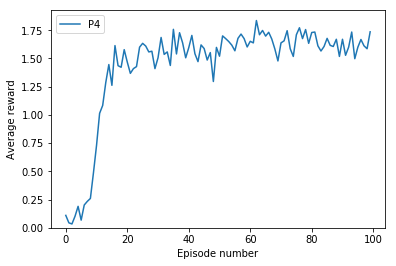

In [84]:
# level, epsilon, episode_length, num_trajectories, n_episode, learning_rate
# {'Importance': , 'Causality': , 'Baseline': }
# r_episode_1, r_reward_1 = REINFORCE('hard', 0.1, 20, 20, 100, 0.1, {'Baseline': 1})
# r_episode_2, r_reward_2 = REINFORCE_Causality('hard', 0.1, 20, 20, 100, 0.1)
# r_episode_3, r_reward_3 = REINFORCE_Baseline('hard', 0.1, 20, 20, 100, 0.1)
r_episode_4, r_reward_4 = REINFORCE_Importance('hard', 0.1, 20, 20, 100, 0.1, 5)
# plt.plot(r_episode_1, r_reward_1, label='P1')
# plt.plot(r_episode_2, r_reward_2, label='P2')
# plt.plot(r_episode_3, r_reward_3, label='P3')
plt.plot(r_episode_4, r_reward_4, label='P4')
plt.xlabel('Episode number')
plt.ylabel('Average reward')
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [75]:
# # {'Importance': add_trajectories, 'Causality': 1, 'Baseline': 1}
# # pool = [[policy, [[[this_dJ, ...], states, actions, rewards], ...num_trajectories], ...n_episode]
# def REINFORCE(level, epsilon, episode_length, num_trajectories, n_episode, learning_rate, mode):
#     env = Policy(level, epsilon)
#     episode_array = [i for i in range(n_episode)]
#     reward_array = []
#     add_trajectories = 0
#     if 'Importance' in mode.keys():
#         pool = []
#         add_trajectories = mode['Importance']
#     for n in range(n_episode):
#         policy = env.get_policy()
#         if 'Baseline' in mode.keys():
#             b_numerator, b_denominator = 0, 0
#             var_b, var_all_b = 0, 0
#         dJ_all = np.zeros(policy.shape)
#         reward_sum = 0
#         var, var_all = 0, 0
#         actual_trajectories = num_trajectories + add_trajectories
#         if 'Importance' in mode.keys():
#             old_trajectories = len(pool)*num_trajectories
#             real_add_trajectories = min(old_trajectories, add_trajectories)
#             actual_trajectories = num_trajectories + real_add_trajectories
#             pool.append([policy, []])
#             index = np.random.choice(range(old_trajectories), real_add_trajectories, replace=False)
#             for t in range(real_add_trajectories):
#                 index_episode = index[t] / num_trajectories
#                 index_trajectory = index[t] % num_trajectories
#                 old_policy = pool[index_episode][0]
#                 this_dJ, states, actions, rewards = pool[index_episode][1][index_trajectory]
#                 total_weight_numerator, total_weight_denominator = 0, 0
#                 for e in range(episode_length):
#                     total_weight_numerator += policy[states[e]][actions[e]]
#                     total_weight_denominator += old_policy[states[e]][actions[e]]
#                 total_weight = total_weight_numerator / total_weight_denominator
#                 reward_sum += total_weight * rewards.sum() / actual_trajectories
#                 var += (la.norm(dJ_sum) * rewards.sum())**2 / actual_trajectories
#                 dJ_all += dJ_sum * rewards.sum() / actual_trajectories
#                 if 'Baseline' in mode.keys():
#                     weight = 
#                     b_numerator += la.norm(dJ_sum)**2 * rewards.sum() / actual_trajectories
#                     b_denominator += la.norm(dJ_sum)**2 / actual_trajectories
#         for t in range(num_trajectories):
#             states, actions, rewards = get_trajectory(env, episode_length)
#             if 'Importance' in mode.keys():
#                 pool[n][1].append([[]])
#             dJ_sum = np.zeros(policy.shape)
#             for e in range(episode_length):
#                 this_dJ = gradient(states[e], actions[e], policy)
# #                 if 'Causality' in mode.keys():
# #                     dJ_sum += this_dJ
# #                 else:
# #                     dJ_sum += this_dJ
#                 if 'Importance' in mode.keys():
#                     pool[n][1][t][0].append(this_dJ)
#             if 'Importance' in mode.keys():
#                 pool[n][1][t].append(states, actions, rewards)
#             dJ_all += dJ_sum * rewards.sum() / actual_trajectories
#             var += (la.norm(dJ_sum) * rewards.sum())**2 / actual_trajectories
#             reward_sum += rewards.sum() / actual_trajectories
#             if 'Baseline' in mode.keys():
#                 b_numerator += la.norm(dJ_sum)**2 * rewards.sum() / actual_trajectories
#                 b_denominator += la.norm(dJ_sum)**2 / actual_trajectories
#         var_all = var - la.norm(dJ_all)**2
#         if 'Baseline' in mode.keys():
#             b = b_numerator / b_denominator
#             dJ_all_b = np.zeros(policy.shape)
#         for t in range(num_trajectories):
#             dJ_b = records[t][0]
#             reward_b = records[t][1].sum()-b
#             dJ_all_b += dJ_b * reward_b / num_trajectories
#             var_b += (la.norm(dJ_b) * reward_b)**2 / num_trajectories
#         var_all_b = var_b - la.norm(dJ_all_b)**2
# #         print('var =', var_all, ', var_b =', var_all_b)
#         env.update(learning_rate * dJ_all_b)
#         reward_array.append(reward_sum / episode_length)
#     states, actions, rewards = get_trajectory(env, episode_length)
#     return episode_array, reward_array, (states, actions, rewards)